In [84]:
# #!/usr/bin/env python

# """Notebook for rapid prompt-based annotation. Box to mask using Segment Anything Model"""

# __author__      = "Sahib Julka <sahib.julka@uni-passau.de>"
# __copyright__   = "GPL"


In [85]:
import torch
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from utils import encode_image
from jupyter_bbox_widget import BBoxWidget


In [86]:
DEVICE = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = os.path.join("sam","sam_vit_h_4b8939.pth")

In [87]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_predictor = SamPredictor(sam)

In [341]:
DATA_PATH = 'processed/images'
IMAGES = []
filenames = []
for fn in os.listdir(DATA_PATH):
    if fn.endswith('chorus1_psd.png'):
        filenames.append(fn)
        IMAGES.append(os.path.join(DATA_PATH, fn))
        
        #widget.image = encode_image(IMAGE_PATH)

In [370]:
i = np.random.randint(1, len(filenames))
widget = BBoxWidget()
widget.image = encode_image(IMAGES[i])
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [360]:
widget.bboxes

[{'x': 22, 'y': 162, 'width': 78, 'height': 175, 'label': ''},
 {'x': 132, 'y': 206, 'width': 111, 'height': 131, 'label': ''},
 {'x': 281, 'y': 182, 'width': 153, 'height': 157, 'label': ''},
 {'x': 468, 'y': 184, 'width': 112, 'height': 125, 'label': ''},
 {'x': 602, 'y': 166, 'width': 201, 'height': 161, 'label': ''},
 {'x': 835, 'y': 176, 'width': 246, 'height': 155, 'label': ''},
 {'x': 1129, 'y': 170, 'width': 114, 'height': 153, 'label': ''},
 {'x': 1312, 'y': 174, 'width': 56, 'height': 169, 'label': ''},
 {'x': 1386, 'y': 180, 'width': 30, 'height': 105, 'label': ''},
 {'x': 1428, 'y': 164, 'width': 34, 'height': 149, 'label': ''},
 {'x': 1523, 'y': 150, 'width': 393, 'height': 169, 'label': ''},
 {'x': 1482, 'y': 235, 'width': 25, 'height': 88, 'label': ''},
 {'x': 1269, 'y': 273, 'width': 25, 'height': 78, 'label': ''},
 {'x': 1271, 'y': 182, 'width': 27, 'height': 53, 'label': ''},
 {'x': 1490, 'y': 162, 'width': 25, 'height': 40, 'label': ''}]

In [372]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}
boxes = []
#box = widget.bboxes[0] if widget.bboxes else default_box
for box in widget.bboxes:
    box = np.array([
        box['x'], 
        box['y'], 
        box['x'] + box['width'], 
        box['y'] + box['height']
    ])
    boxes.append(box)

In [373]:
boxes = np.array(boxes)


In [374]:
import cv2
import numpy as np
import supervision as sv


boxes = torch.Tensor(boxes).to(DEVICE)
image_bgr = cv2.imread(IMAGES[i])
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)
transformed_boxes = mask_predictor.transform.apply_boxes_torch(boxes, image_rgb.shape[:2])


masks, scores, logits = mask_predictor.predict_torch(
    point_coords = None,
    point_labels = None,
    boxes=transformed_boxes,
    multimask_output=False
)
mask = masks.sum(axis = 0).cpu().numpy()

RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1, 256, 256] because the unspecified dimension size -1 can be any value and is ambiguous

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=mask),
    mask=mask
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

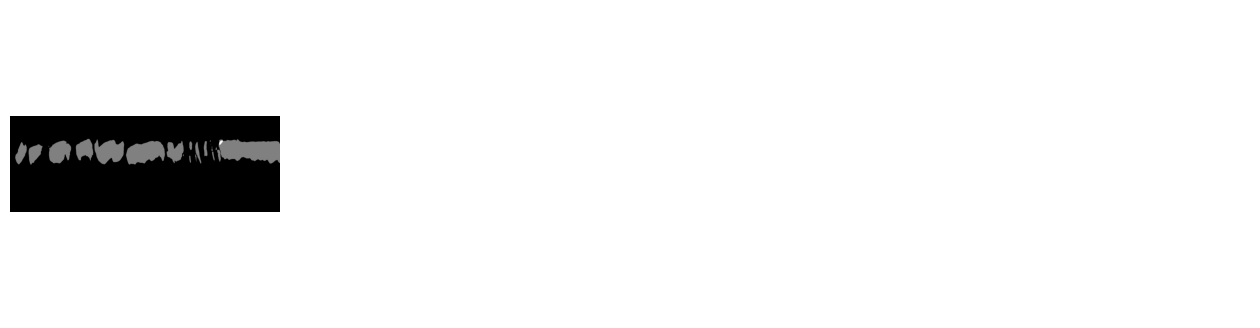

In [365]:
import supervision as v

sv.plot_images_grid(
    images=mask,
    grid_size=(1, 4),
    size=(16, 4)
)

In [366]:
os.makedirs("processed/masks+/", exist_ok = True)
np.save('processed/masks+/{}.npy'.format(filenames[i].split('.png')[0]), mask)